In [1]:
import os
os.chdir('..')

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

import random

import scipy.stats as st

import tensorflow as tf

import seaborn as sns
sns.set_style("whitegrid")

from modules.MMD import mmd_loss

from tgan.model import TGANModel

# For the Python notebook
%matplotlib inline
%reload_ext autoreload
%autoreload 2

# Load datasets

In [3]:
df = pd.read_csv('../data/Chicago/full.csv')

In [4]:
tgan = TGANModel.load('output/trained')

[0710 18:12:18 @registry.py:126] gen/LSTM/00/FC input: [200, 100]
[0710 18:12:18 @registry.py:134] gen/LSTM/00/FC output: [200, 100]
[0710 18:12:18 @registry.py:126] gen/LSTM/00/FC2 input: [200, 100]
[0710 18:12:18 @registry.py:134] gen/LSTM/00/FC2 output: [200, 5]
[0710 18:12:18 @registry.py:126] gen/LSTM/00/FC3 input: [200, 5]
[0710 18:12:18 @registry.py:134] gen/LSTM/00/FC3 output: [200, 100]
[0710 18:12:18 @registry.py:126] gen/LSTM/01/FC input: [200, 100]
[0710 18:12:18 @registry.py:134] gen/LSTM/01/FC output: [200, 100]
[0710 18:12:18 @registry.py:126] gen/LSTM/01/FC2 input: [200, 100]
[0710 18:12:18 @registry.py:134] gen/LSTM/01/FC2 output: [200, 7]
[0710 18:12:18 @registry.py:126] gen/LSTM/01/FC3 input: [200, 7]
[0710 18:12:18 @registry.py:134] gen/LSTM/01/FC3 output: [200, 100]
[0710 18:12:18 @registry.py:126] gen/LSTM/02/FC input: [200, 100]
[0710 18:12:18 @registry.py:134] gen/LSTM/02/FC output: [200, 100]
[0710 18:12:18 @registry.py:126] gen/LSTM/02/FC2 input: [200, 100]
[0

[0710 18:12:20 @sessinit.py:87] WRN The following variables are in the checkpoint, but not found in the graph: global_step, optimize/beta1_power, optimize/beta2_power
[0710 18:12:21 @sessinit.py:114] Restoring checkpoint from output/model/model-200000 ...


In [5]:
samples = tgan.sample(len(df))

samples.head()

438it [00:11, 36.88it/s]                      


,choice,travel_dow,trip_purpose,distance,departure_hour,departure_min,hh_vehicles,hh_size,hh_bikes,hh_descr,hh_income,gender,age,license,education_level,work_status
0,drive,1,SHOPPING,0.828375,14.0,40.0,2,4,0,1,7,0,51,1.0,6,PTE
1,drive,3,HOME_OTHER,4.837392,22.0,15.0,2,2,0,1,7,0,60,1.0,5,FTE
2,passenger,5,HOME_OTHER,4.920022,20.0,15.0,1,1,0,1,4,1,70,1.0,3,Retired
3,passenger,5,HOME_OTHER,0.823392,15.0,15.0,2,4,4,1,7,1,2,0.0,1,Unknown
4,drive,3,HOME_WORK,13.083723,10.0,30.0,2,4,0,1,7,1,62,1.0,6,FTE


## Transform all columns in numerical values

In [6]:
ints = ['travel_dow', 'hh_vehicles', 'hh_size', 'hh_bikes', 'hh_descr', 'hh_income', 'gender', 'education_level', 'age']
floats = ['departure_hour', 'departure_min', 'license']

In [7]:
dct = {}

for i in ints:
    dct[i] = 'int64'
    
for i in floats:
    dct[i] = 'float64'

In [8]:
samples = samples.astype(dct)
df = df.astype(dct)

In [9]:
choices = {}
trip_purpose = {}
work_status = {}

for c in ['choice', 'trip_purpose', 'work_status']: 
    dct = {}
    
    for n, i in enumerate(df[c].unique()):
        if c == 'choice':
            choices[n] = i
            
        if c == 'trip_purpose':
            trip_purpose[n] = i
            
        if c == 'work_status':
            work_status[n] = i
        
        dct[i] = n
        
    df = df.replace(dct)
    samples = samples.replace(dct)

In [10]:
samples.dtypes

choice               int64
travel_dow           int64
trip_purpose         int64
distance           float64
departure_hour     float64
departure_min      float64
hh_vehicles          int64
hh_size              int64
hh_bikes             int64
hh_descr             int64
hh_income            int64
gender               int64
age                  int64
license            float64
education_level      int64
work_status          int64
dtype: object

In [11]:
df.dtypes

choice               int64
travel_dow           int64
trip_purpose         int64
distance           float64
departure_hour     float64
departure_min      float64
hh_vehicles          int64
hh_size              int64
hh_bikes             int64
hh_descr             int64
hh_income            int64
gender               int64
age                  int64
license            float64
education_level      int64
work_status          int64
dtype: object

## Create a dummy dataset using only the proportions of a single column

In [12]:
dct = {}

for col in df.columns:
    
    counts = df[col].value_counts(normalize=True)
    pop = counts.index
    weights = counts.values
    
    dct[col] = random.choices(population=pop, weights=weights, k=len(df))

In [13]:
dummy = pd.DataFrame(dct)

In [14]:
dummy.dtypes

choice               int64
travel_dow           int64
trip_purpose         int64
distance           float64
departure_hour     float64
departure_min      float64
hh_vehicles          int64
hh_size              int64
hh_bikes             int64
hh_descr             int64
hh_income            int64
gender               int64
age                  int64
license            float64
education_level      int64
work_status          int64
dtype: object

# Values

In [15]:
cols = []

uniques = []

for i in df.columns:
    uniques.append(len(df[i].unique()))
    
idx = np.argsort(np.array(uniques))

In [16]:
uniques

[5, 7, 7, 44388, 24, 60, 9, 8, 8, 3, 7, 2, 97, 2, 6, 8]

In [17]:
idx[::-1]

array([ 3, 12,  5,  4,  6, 15,  8,  7, 10,  2,  1, 14,  0,  9, 13, 11])

In [18]:
for col in df.columns[idx[::-1]]:    
    tmp_df = df[col]
    tmp_sample = samples[col]
    tmp_dummy = dummy[col]
    
    tstat1, tpval1 = st.ttest_ind(tmp_df, tmp_sample, equal_var=False)
    
    tres1 = 'cadmiumgreen'
    if tpval1 < 0.05:
        tres1 = 'red'
        
    ksstat1, kspval1 = st.ks_2samp(tmp_df, tmp_sample)

    ksres1 = 'cadmiumgreen'
    if kspval1 < 0.05:
        ksres1 = 'red'
        
        
    tstat2, tpval2 = st.ttest_ind(tmp_df, tmp_dummy, equal_var=False)
    
    tres2 = 'cadmiumgreen'
    if tpval2 < 0.05:
        tres2 = 'red'
        
    ksstat2, kspval2 = st.ks_2samp(tmp_df, tmp_dummy)

    ksres2 = 'cadmiumgreen'
    if kspval2 < 0.05:
        ksres2 = 'red'
        
    
    print('\\begin{table}[H]')
    print('    \\centering')
    print('    \\begin{tabular}{c|c|cc}')
    print('         metrics & original & synthetic & dummy \\\\ \\hline')
    print('         max & {:.3f} & {:.3f} & {:.3f} \\\\ \\hline'.format(np.max(tmp_df), np.max(tmp_sample), np.max(tmp_dummy)))
    print('         median & {:.3f} & {:.3f} & {:.3f} \\\\ \\hline'.format(np.median(tmp_df), np.median(tmp_sample), np.median(tmp_dummy)))
    print('         mean & {:.3f} & {:.3f} & {:.3f} \\\\ \\hline'.format(np.mean(tmp_df), np.mean(tmp_sample), np.mean(tmp_dummy)))
    print('         min & {:.3f} & {:.3f} & {:.3f} \\\\ \\hline\\hline'.format(np.min(tmp_df), np.min(tmp_sample), np.min(tmp_dummy)))
    print('         t-test & / & {{\\bf\\color{{{}}} {:.3f} ({:.3E})}} & {{\\bf\\color{{{}}} {:.3f} ({:.3E})}} \\\\ \\hline'.format(tres1, tstat1, tpval1, tres2, tstat2, tpval2))
    print('         KS & / & {{\\bf\\color{{{}}} {:.3f} ({:.3E})}} & {{\\bf\\color{{{}}} {:.3f} ({:.3E})}} \\\\'.format(ksres1, ksstat1, kspval1, ksres2, ksstat2, kspval2))
    print('    \end{tabular}')
    print('    \caption{{\\texttt{{{}}}}}'.format(col.replace('_', '\_')))
    print('    \label{{tab:{}}}'.format(col))
    print('\end{table}')
    print('')
    

\begin{table}[H]
    \centering
    \begin{tabular}{c|c|cc}
         metrics & original & synthetic & dummy \\ \hline
         max & 71.582 & 52.624 & 71.582 \\ \hline
         median & 2.179 & 2.577 & 2.169 \\ \hline
         mean & 4.926 & 5.023 & 4.924 \\ \hline
         min & 0.000 & -0.129 & 0.000 \\ \hline\hline
         t-test & / & {\bf\color{red} -2.881 (3.962E-03)} & {\bf\color{cadmiumgreen} 0.057 (9.545E-01)} \\ \hline
         KS & / & {\bf\color{red} 0.145 (0.000E+00)} & {\bf\color{cadmiumgreen} 0.003 (8.786E-01)} \\
    \end{tabular}
    \caption{\texttt{distance}}
    \label{tab:distance}
\end{table}

\begin{table}[H]
    \centering
    \begin{tabular}{c|c|cc}
         metrics & original & synthetic & dummy \\ \hline
         max & 98.000 & 87.000 & 98.000 \\ \hline
         median & 46.000 & 45.000 & 46.000 \\ \hline
         mean & 43.535 & 38.283 & 43.610 \\ \hline
         min & 0.000 & 0.000 & 0.000 \\ \hline\hline
         t-test & / & {\bf\color{red} 50.628 (0.000

# Test the distributions

In [19]:
cont_cols = [3, 4, 5, 12]

In [20]:
msk = []

for i in range(len(df.columns)):
    msk.append(i not in cont_cols)

In [21]:
df.columns[msk]

Index(['choice', 'travel_dow', 'trip_purpose', 'hh_vehicles', 'hh_size',
       'hh_bikes', 'hh_descr', 'hh_income', 'gender', 'license',
       'education_level', 'work_status'],
      dtype='object')

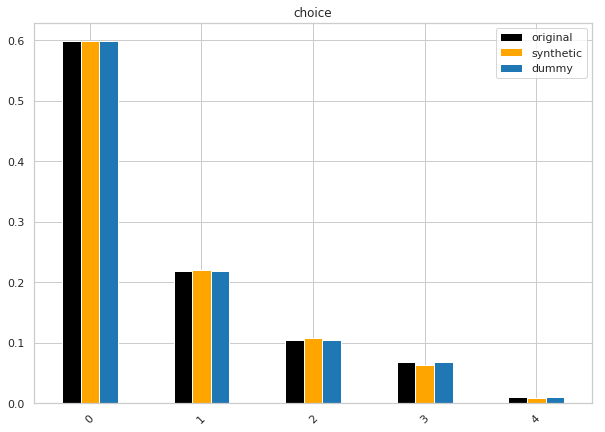

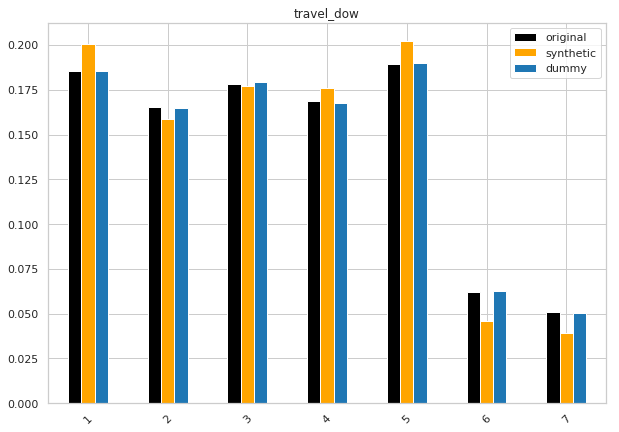

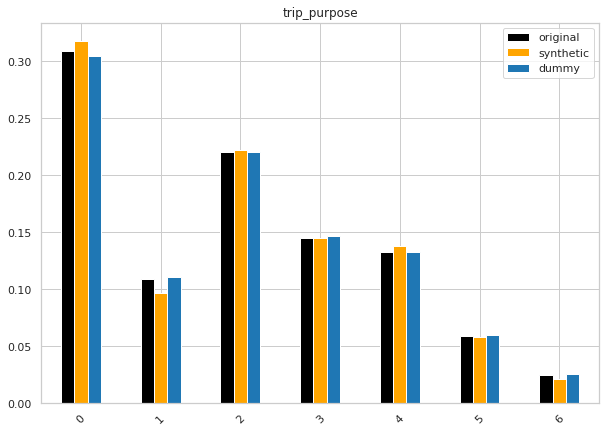

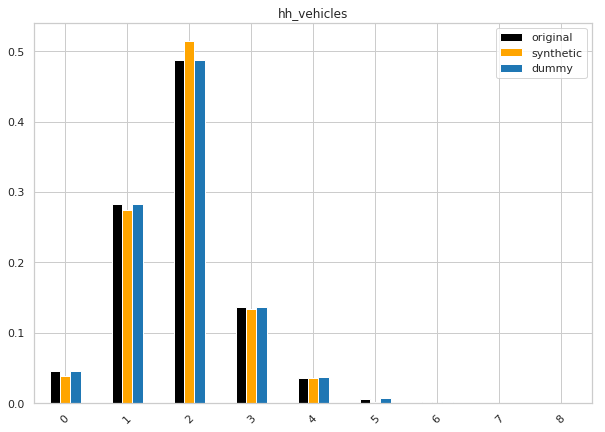

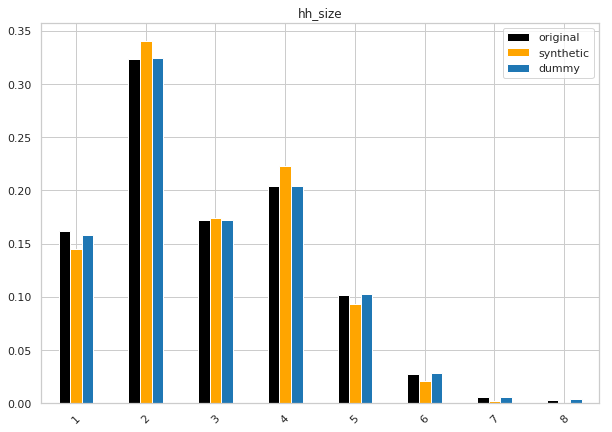

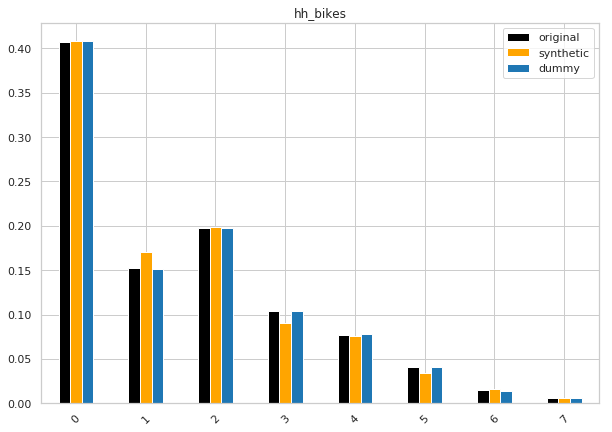

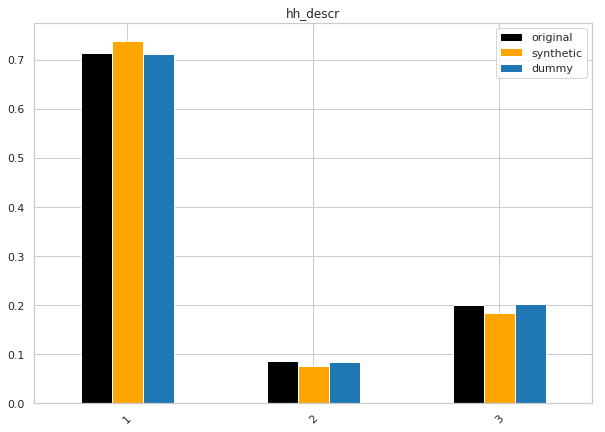

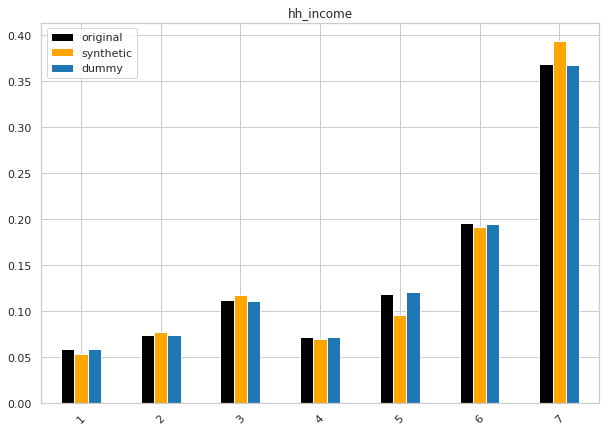

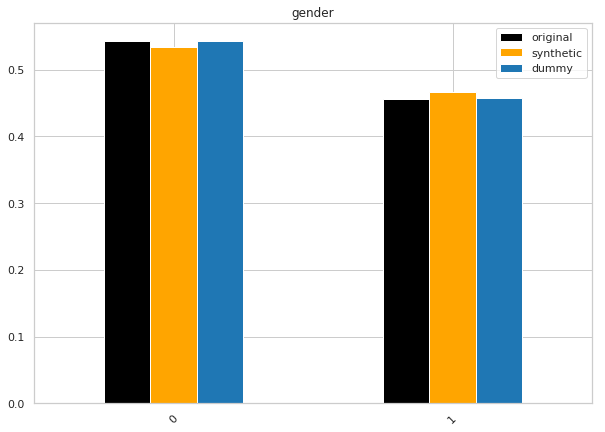

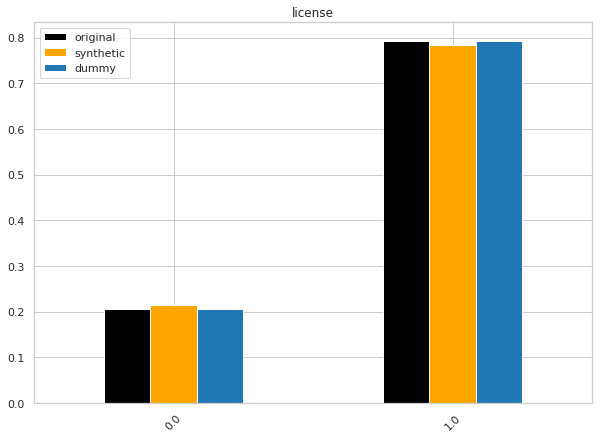

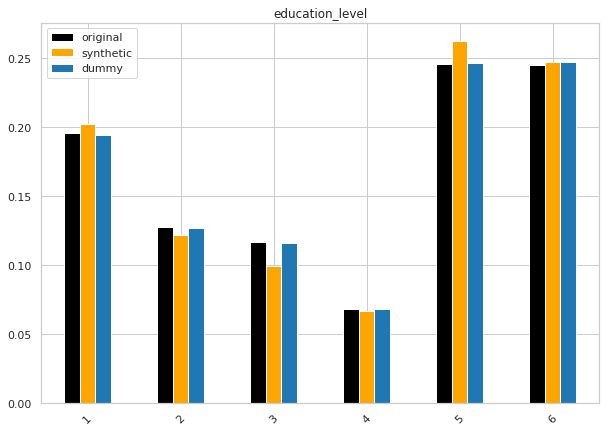

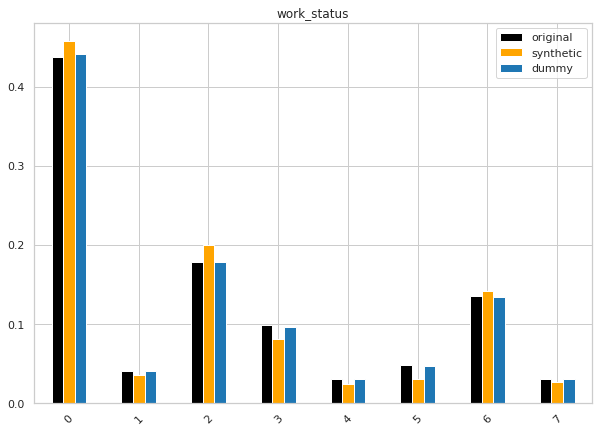

In [29]:
for col in df.columns[msk]:
    
    prob_df = df[col].value_counts(normalize=True)
    prob_sample = samples[col].value_counts(normalize=True)
    prob_dummy = dummy[col].value_counts(normalize=True)
    
    dct = {'original': [], 'synthetic': [], 'dummy': []}
    
    idx = np.sort(prob_df.index)
    
    for i in idx:
        
        dct['original'].append(prob_df.loc[i])
        try:
            dct['synthetic'].append(prob_sample.loc[i])
        except:
            dct['synthetic'].append(0)   
        dct['dummy'].append(prob_dummy.loc[i])
        
    tmp_df = pd.DataFrame(dct, index=idx)
    
    tmp_df.plot(figsize=(10,7), kind='bar', color=['black', 'orange', 'tab:blue'])

    plt.legend()
    
    plt.xticks(rotation=45)
    plt.title(col)

    plt.savefig('../figures/tgan-chicago/distributions/' + col + '.pdf', bbox_inches='tight')
    plt.savefig('../figures/tgan-chicago/distributions/' + col + '.png', bbox_inches='tight')

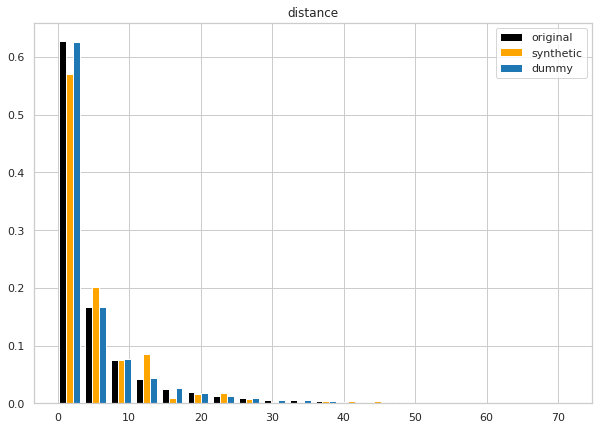

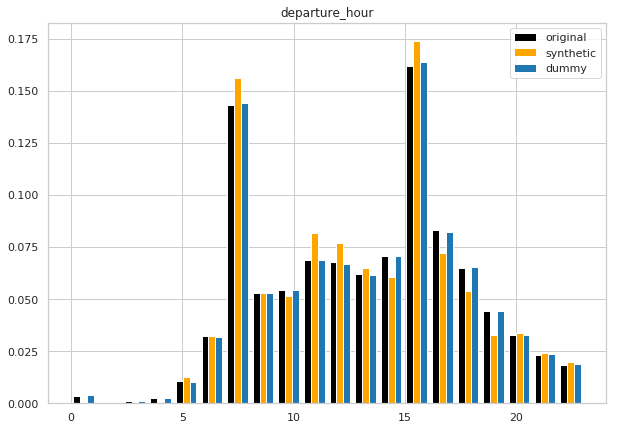

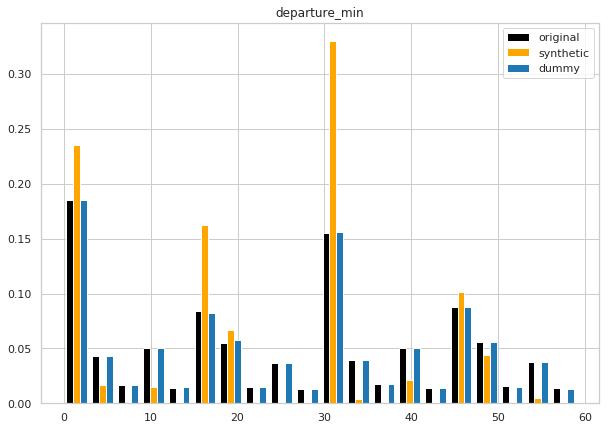

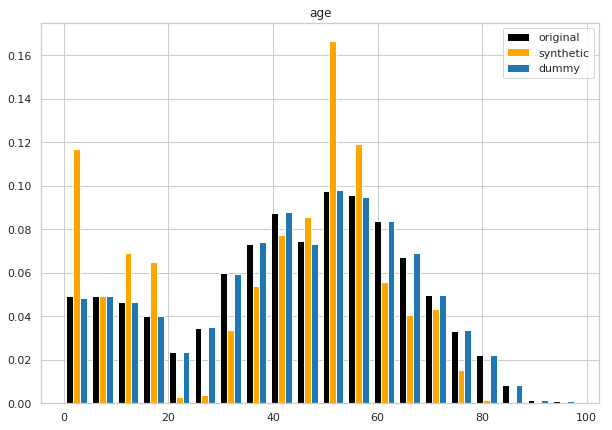

In [30]:
for col in df.columns[~np.array(msk)]:
    
    val_df = df[col]
    val_sample = samples[col]
    val_dummy = dummy[col]
    
    plt.figure(figsize=(10,7))
    
    bins=np.histogram(np.hstack((val_df,val_sample)), bins=20)[1] 
    
    plt.hist([val_df, val_sample, val_dummy],
             bins=bins, weights = [np.ones_like(val_df)/len(val_df), np.ones_like(val_sample)/len(val_sample), np.ones_like(val_dummy)/len(val_dummy)],
             label=['original', 'synthetic', 'dummy'], color=['black', 'orange', 'tab:blue'])
    
    plt.legend()
    plt.title(col)
    
    plt.savefig('../figures/tgan-chicago/distributions/' + col + '.pdf', bbox_inches='tight')
    plt.savefig('../figures/tgan-chicago/distributions/' + col + '.png', bbox_inches='tight')


# Sub distribution

<Figure size 720x504 with 0 Axes>

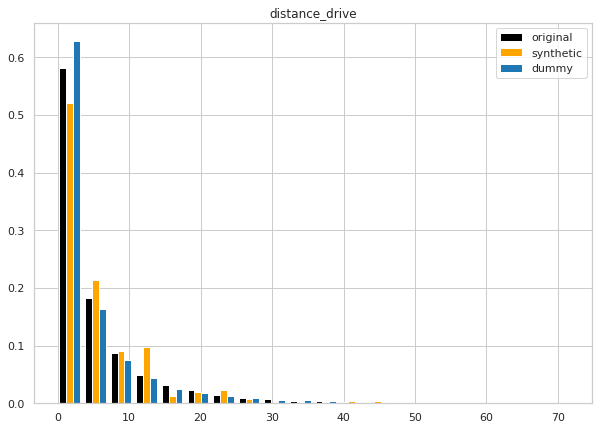

<Figure size 720x504 with 0 Axes>

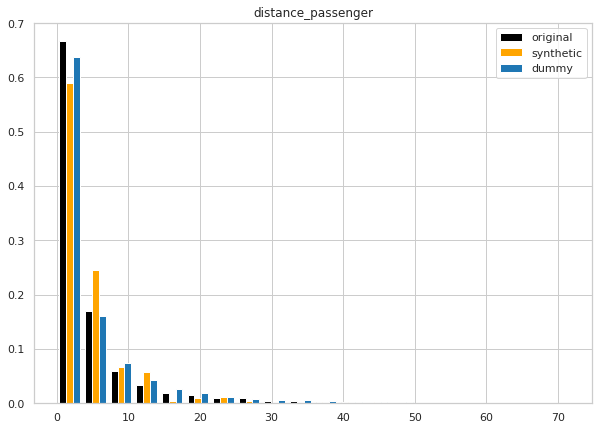

<Figure size 720x504 with 0 Axes>

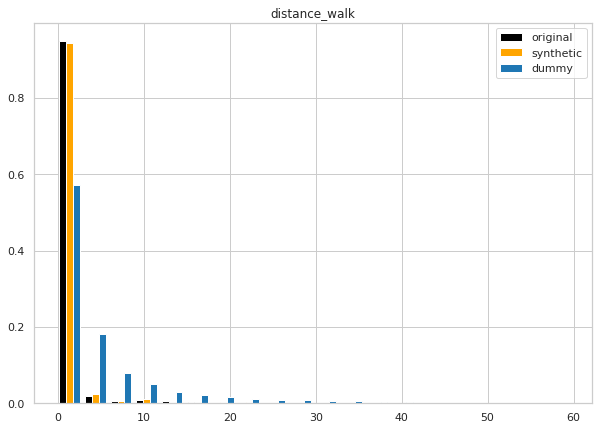

<Figure size 720x504 with 0 Axes>

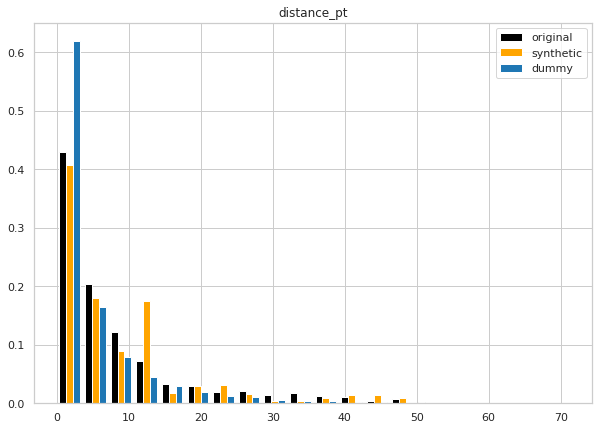

<Figure size 720x504 with 0 Axes>

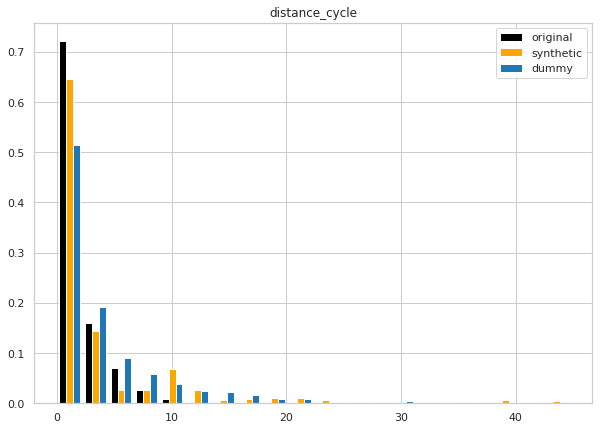

In [31]:
for i in df.choice.unique():

    plt.figure(figsize=(10,7))

    val_df = df[df.choice == i].distance
    val_sample = samples[samples.choice == i].distance
    val_dummy = dummy[dummy.choice == i].distance

    plt.figure(figsize=(10,7))

    bins=np.histogram(np.hstack((val_df,val_sample)), bins=20)[1] 
    
    plt.hist([val_df, val_sample, val_dummy],
             bins=bins, weights = [np.ones_like(val_df)/len(val_df), np.ones_like(val_sample)/len(val_sample), np.ones_like(val_dummy)/len(val_dummy)],
             label=['original', 'synthetic', 'dummy'], color=['black', 'orange', 'tab:blue'])
    
    
    plt.legend()
    
    plt.title('distance_' + choices[i])
    
    plt.savefig('../figures/tgan-chicago/sub/distance_' + choices[i] + '.pdf', bbox_inches='tight')
    plt.savefig('../figures/tgan-chicago/sub/distance_' + choices[i] + '.png', bbox_inches='tight')


<Figure size 720x504 with 0 Axes>

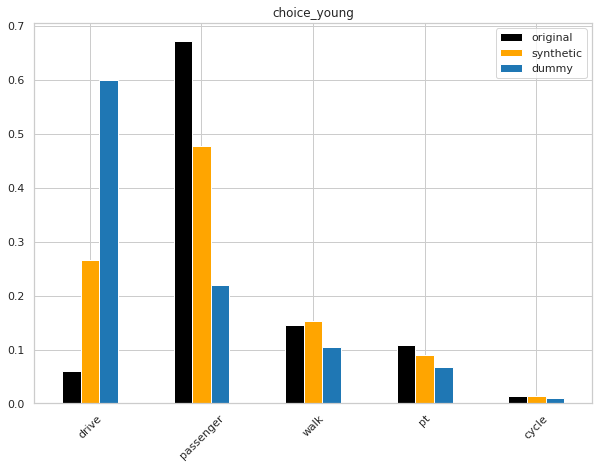

In [32]:
val_df = df[df.age <= 18].choice
val_sample = samples[samples.age <= 18].choice
val_dummy = dummy[dummy.age <= 18].choice

prob_df = val_df.value_counts(normalize=True)
prob_sample = val_sample.value_counts(normalize=True)
prob_dummy = val_dummy.value_counts(normalize=True)

dct = {'original': [], 'synthetic': [], 'dummy': []}

idx = np.sort(prob_df.index)

for i in idx:

    dct['original'].append(prob_df.loc[i])
    try:
        dct['synthetic'].append(prob_sample.loc[i])
    except:
        dct['synthetic'].append(0)   
    dct['dummy'].append(prob_dummy.loc[i])
    
tmp_df = pd.DataFrame(dct, index=idx)


plt.figure(figsize=(10,7))

tmp_df.plot(figsize=(10,7), kind='bar', color=['black', 'orange', 'tab:blue'])

plt.legend()

plt.xticks(list(range(len(choices))), list(choices.values()), rotation=45)

plt.title('choice_young')

plt.savefig('../figures/tgan-chicago/sub/choice_young.pdf', bbox_inches='tight')
plt.savefig('../figures/tgan-chicago/sub/choice_young.png', bbox_inches='tight')


<Figure size 720x504 with 0 Axes>

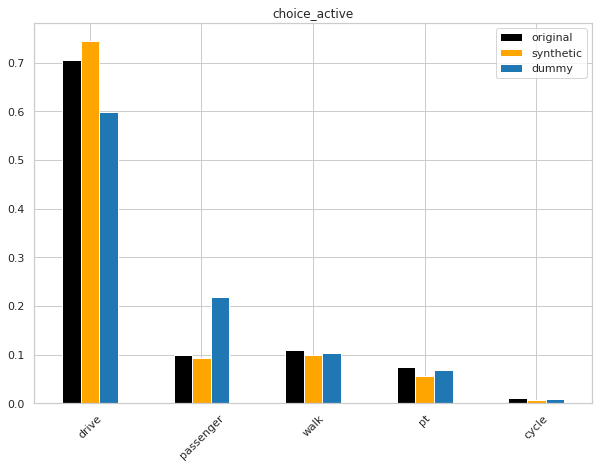

In [33]:
val_df = df[(df.age > 18) & (df.age <= 50)].choice
val_sample = samples[(samples.age > 18) & (samples.age <= 50)].choice
val_dummy = dummy[(dummy.age > 18) & (dummy.age <= 50)].choice

prob_df = val_df.value_counts(normalize=True)
prob_sample = val_sample.value_counts(normalize=True)
prob_dummy = val_dummy.value_counts(normalize=True)

dct = {'original': [], 'synthetic': [], 'dummy': []}

idx = np.sort(prob_df.index)

for i in idx:

    dct['original'].append(prob_df.loc[i])
    try:
        dct['synthetic'].append(prob_sample.loc[i])
    except:
        dct['synthetic'].append(0)   
    dct['dummy'].append(prob_dummy.loc[i])
    
tmp_df = pd.DataFrame(dct, index=idx)


plt.figure(figsize=(10,7))

tmp_df.plot(figsize=(10,7), kind='bar', color=['black', 'orange', 'tab:blue'])

plt.legend()

plt.xticks(list(range(len(choices))), list(choices.values()), rotation=45)

plt.title('choice_active')

plt.savefig('../figures/tgan-chicago/sub/choice_active.pdf', bbox_inches='tight')
plt.savefig('../figures/tgan-chicago/sub/choice_active.png', bbox_inches='tight')


<Figure size 720x504 with 0 Axes>

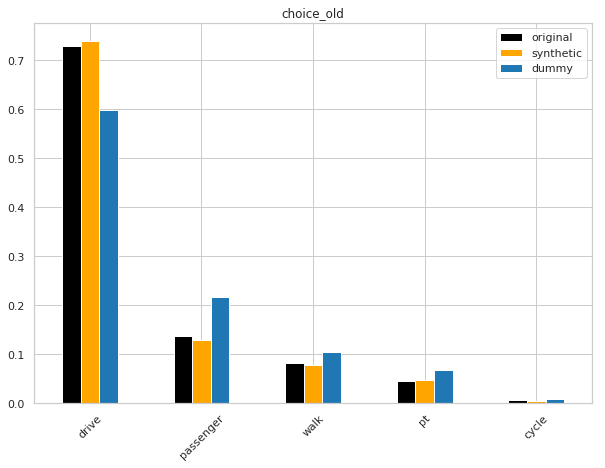

In [34]:
val_df = df[(df.age > 50)].choice
val_sample = samples[(samples.age > 50)].choice
val_dummy = dummy[dummy.age > 50].choice

prob_df = val_df.value_counts(normalize=True)
prob_sample = val_sample.value_counts(normalize=True)
prob_dummy = val_dummy.value_counts(normalize=True)

dct = {'original': [], 'synthetic': [], 'dummy': []}

idx = np.sort(prob_df.index)

for i in idx:

    dct['original'].append(prob_df.loc[i])
    try:
        dct['synthetic'].append(prob_sample.loc[i])
    except:
        dct['synthetic'].append(0)   
    dct['dummy'].append(prob_dummy.loc[i])
    
tmp_df = pd.DataFrame(dct, index=idx)


plt.figure(figsize=(10,7))

tmp_df.plot(figsize=(10,7), kind='bar', color=['black', 'orange', 'tab:blue'])

plt.legend()

plt.xticks(list(range(len(choices))), list(choices.values()), rotation=45)

plt.title('choice_old')

plt.savefig('../figures/tgan-chicago/sub/choice_old.pdf', bbox_inches='tight')
plt.savefig('../figures/tgan-chicago/sub/choice_old.png', bbox_inches='tight')


<Figure size 720x504 with 0 Axes>

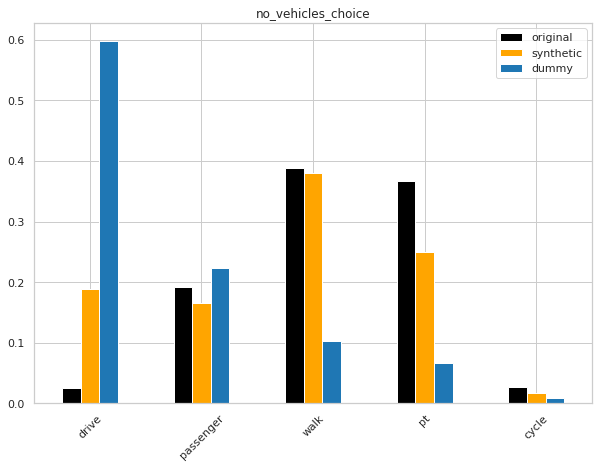

In [35]:
val_df = df[df.hh_vehicles == 0].choice
val_sample = samples[samples.hh_vehicles == 0].choice
val_dummy = dummy[dummy.hh_vehicles == 0].choice

prob_df = val_df.value_counts(normalize=True)
prob_sample = val_sample.value_counts(normalize=True)
prob_dummy = val_dummy.value_counts(normalize=True)

dct = {'original': [], 'synthetic': [], 'dummy': []}

idx = np.sort(prob_df.index)

for i in idx:

    dct['original'].append(prob_df.loc[i])
    try:
        dct['synthetic'].append(prob_sample.loc[i])
    except:
        dct['synthetic'].append(0)   
    dct['dummy'].append(prob_dummy.loc[i])
    
tmp_df = pd.DataFrame(dct, index=idx)


plt.figure(figsize=(10,7))

tmp_df.plot(figsize=(10,7), kind='bar', color=['black', 'orange', 'tab:blue'])

plt.legend()

plt.xticks(list(range(len(choices))), list(choices.values()), rotation=45)

plt.title('no_vehicles_choice')

plt.savefig('../figures/tgan-chicago/sub/no_vehicles_choice.pdf', bbox_inches='tight')
plt.savefig('../figures/tgan-chicago/sub/no_vehicles_choice.png', bbox_inches='tight')

<Figure size 720x504 with 0 Axes>

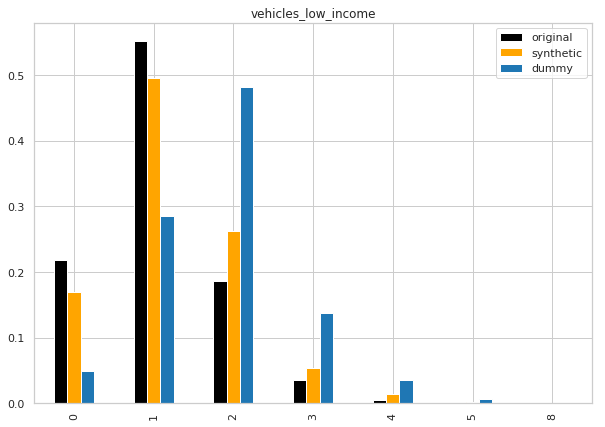

In [36]:
val_df = df[df.hh_income <= 2].hh_vehicles
val_sample = samples[samples.hh_income <= 2].hh_vehicles
val_dummy = dummy[dummy.hh_income <= 2].hh_vehicles

prob_df = val_df.value_counts(normalize=True)
prob_sample = val_sample.value_counts(normalize=True)
prob_dummy = val_dummy.value_counts(normalize=True)

dct = {'original': [], 'synthetic': [], 'dummy': []}

idx = np.sort(prob_df.index)

for i in idx:

    dct['original'].append(prob_df.loc[i])
    try:
        dct['synthetic'].append(prob_sample.loc[i])
    except:
        dct['synthetic'].append(0)   
    dct['dummy'].append(prob_dummy.loc[i])
    
tmp_df = pd.DataFrame(dct, index=idx)


plt.figure(figsize=(10,7))

tmp_df.plot(figsize=(10,7), kind='bar', color=['black', 'orange', 'tab:blue'])

plt.legend()

plt.title('vehicles_low_income')

plt.savefig('../figures/tgan-chicago/sub/vehicles_low_income.pdf', bbox_inches='tight')
plt.savefig('../figures/tgan-chicago/sub/vehicles_low_income.png', bbox_inches='tight')

<Figure size 720x504 with 0 Axes>

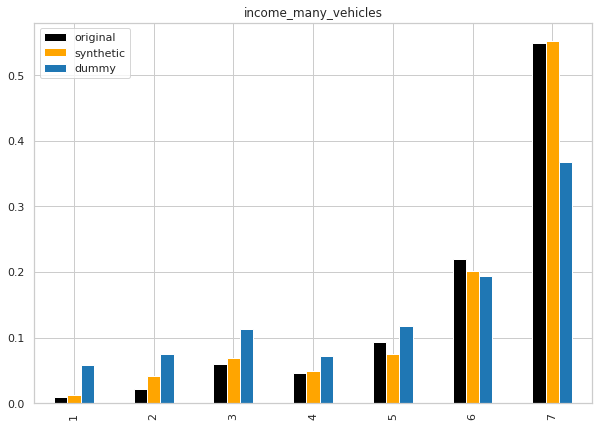

In [37]:
val_df = df[df.hh_vehicles > 2].hh_income
val_sample = samples[samples.hh_vehicles > 2].hh_income
val_dummy = dummy[dummy.hh_vehicles > 2].hh_income

prob_df = val_df.value_counts(normalize=True)
prob_sample = val_sample.value_counts(normalize=True)
prob_dummy = val_dummy.value_counts(normalize=True)

dct = {'original': [], 'synthetic': [], 'dummy': []}

idx = np.sort(prob_df.index)

for i in idx:

    dct['original'].append(prob_df.loc[i])
    try:
        dct['synthetic'].append(prob_sample.loc[i])
    except:
        dct['synthetic'].append(0)   
    dct['dummy'].append(prob_dummy.loc[i])
    
tmp_df = pd.DataFrame(dct, index=idx)


plt.figure(figsize=(10,7))

tmp_df.plot(figsize=(10,7), kind='bar', color=['black', 'orange', 'tab:blue'])

plt.legend()

plt.title('income_many_vehicles')

plt.savefig('../figures/tgan-chicago/sub/income_many_vehicles.pdf', bbox_inches='tight')
plt.savefig('../figures/tgan-chicago/sub/income_many_vehicles.png', bbox_inches='tight')

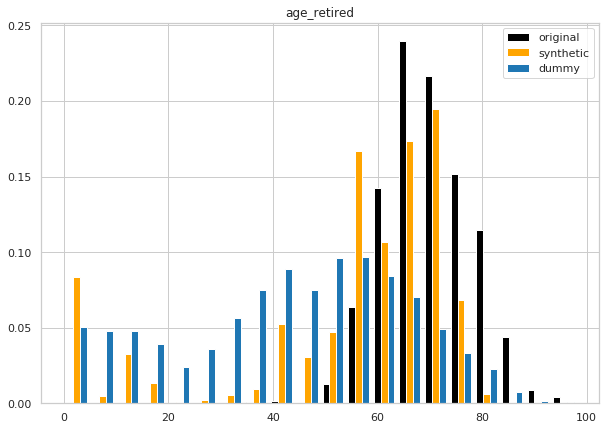

In [38]:
val_df = df[df.work_status == 6].age
val_sample = samples[samples.work_status == 6].age
val_dummy = dummy[dummy.work_status == 6].age

plt.figure(figsize=(10,7))

bins=np.histogram(np.hstack((val_df,val_sample)), bins=20)[1] 

plt.hist([val_df, val_sample, val_dummy],
         bins=bins, weights = [np.ones_like(val_df)/len(val_df), np.ones_like(val_sample)/len(val_sample), np.ones_like(val_dummy)/len(val_dummy)],
         label=['original', 'synthetic', 'dummy'], color=['black', 'orange', 'tab:blue'])


plt.legend()

plt.title('age_retired')

plt.savefig('../figures/tgan-chicago/sub/age_retired.pdf', bbox_inches='tight')
plt.savefig('../figures/tgan-chicago/sub/age_retired.png', bbox_inches='tight')

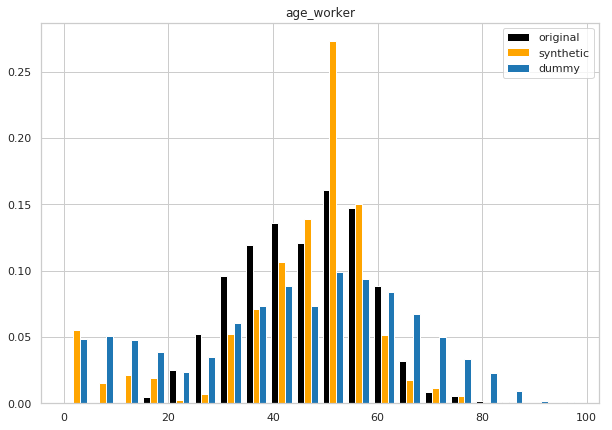

In [39]:
val_df = df[df.work_status == 0].age
val_sample = samples[samples.work_status == 0].age
val_dummy = dummy[dummy.work_status == 0].age

plt.figure(figsize=(10,7))

bins=np.histogram(np.hstack((val_df,val_sample)), bins=20)[1] 

plt.hist([val_df, val_sample, val_dummy],
         bins=bins, weights = [np.ones_like(val_df)/len(val_df), np.ones_like(val_sample)/len(val_sample), np.ones_like(val_dummy)/len(val_dummy)],
         label=['original', 'synthetic', 'dummy'], color=['black', 'orange', 'tab:blue'])


plt.legend()

plt.title('age_worker')

plt.savefig('../figures/tgan-chicago/sub/age_worker.pdf', bbox_inches='tight')
plt.savefig('../figures/tgan-chicago/sub/age_worker.png', bbox_inches='tight')

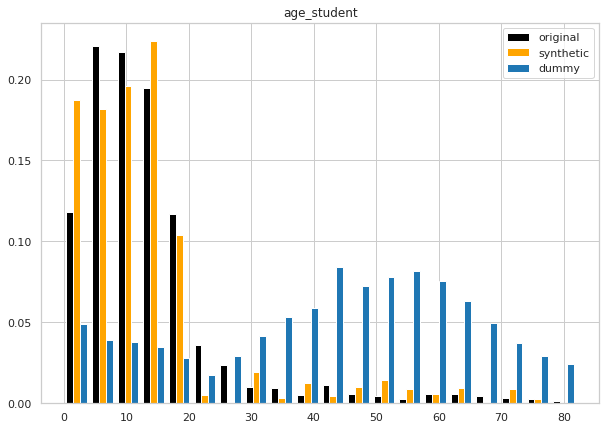

In [40]:
val_df = df[df.work_status == 2].age
val_sample = samples[samples.work_status == 2].age
val_dummy = dummy[dummy.work_status == 2].age

plt.figure(figsize=(10,7))

bins=np.histogram(np.hstack((val_df,val_sample)), bins=20)[1] 

plt.hist([val_df, val_sample, val_dummy],
         bins=bins, weights = [np.ones_like(val_df)/len(val_df), np.ones_like(val_sample)/len(val_sample), np.ones_like(val_dummy)/len(val_dummy)],
         label=['original', 'synthetic', 'dummy'], color=['black', 'orange', 'tab:blue'])


plt.legend()

plt.title('age_student')

plt.savefig('../figures/tgan-chicago/sub/age_student.pdf', bbox_inches='tight')
plt.savefig('../figures/tgan-chicago/sub/age_student.png', bbox_inches='tight')

<Figure size 720x504 with 0 Axes>

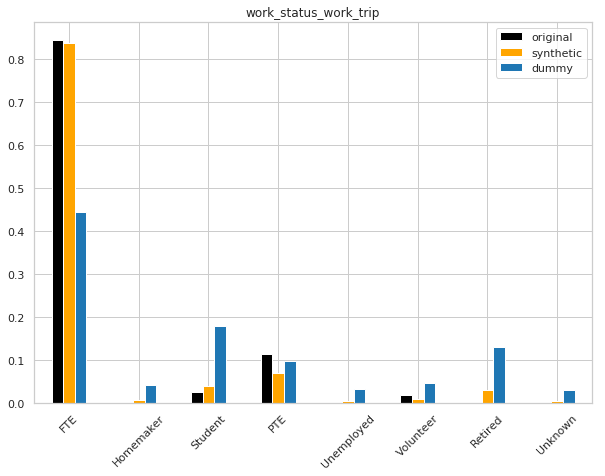

In [41]:
val_df = df[df.trip_purpose == 4].work_status
val_sample = samples[samples.trip_purpose == 4].work_status
val_dummy = dummy[dummy.trip_purpose == 4].work_status

prob_df = val_df.value_counts(normalize=True)
prob_sample = val_sample.value_counts(normalize=True)
prob_dummy = val_dummy.value_counts(normalize=True)

dct = {'original': [], 'synthetic': [], 'dummy': []}

idx = np.sort(prob_dummy.index)

for i in idx:
    
    try:
        dct['original'].append(prob_df.loc[i])
    except:
        dct['original'].append(0)
    try:
        dct['synthetic'].append(prob_sample.loc[i])
    except:
        dct['synthetic'].append(0)   
    dct['dummy'].append(prob_dummy.loc[i])
    
tmp_df = pd.DataFrame(dct, index=idx)

plt.figure(figsize=(10,7))

tmp_df.plot(figsize=(10,7), kind='bar', color=['black', 'orange', 'tab:blue'])

plt.legend()

plt.xticks(list(range(len(work_status))), list(work_status.values()), rotation=45)

plt.title('work_status_work_trip')

plt.savefig('../figures/tgan-chicago/sub/work_status_work_trip.pdf', bbox_inches='tight')
plt.savefig('../figures/tgan-chicago/sub/work_status_work_trip.png', bbox_inches='tight')

<Figure size 720x504 with 0 Axes>

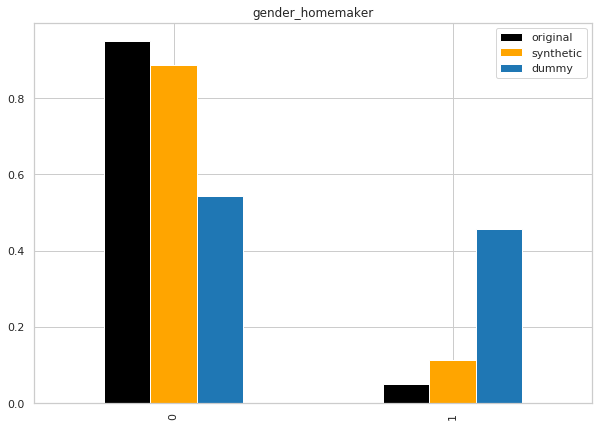

In [42]:
val_df = df[df.work_status == 1].gender
val_sample = samples[samples.work_status == 1].gender
val_dummy = dummy[dummy.work_status == 1].gender

prob_df = val_df.value_counts(normalize=True)
prob_sample = val_sample.value_counts(normalize=True)
prob_dummy = val_dummy.value_counts(normalize=True)

dct = {'original': [], 'synthetic': [], 'dummy': []}

idx = np.sort(prob_dummy.index)

for i in idx:
    
    try:
        dct['original'].append(prob_df.loc[i])
    except:
        dct['original'].append(0)
    try:
        dct['synthetic'].append(prob_sample.loc[i])
    except:
        dct['synthetic'].append(0)   
    dct['dummy'].append(prob_dummy.loc[i])
    
tmp_df = pd.DataFrame(dct, index=idx)

plt.figure(figsize=(10,7))

tmp_df.plot(figsize=(10,7), kind='bar', color=['black', 'orange', 'tab:blue'])

plt.legend()

plt.title('gender_homemaker')

plt.savefig('../figures/tgan-chicago/sub/gender_homemaker.pdf', bbox_inches='tight')
plt.savefig('../figures/tgan-chicago/sub/gender_homemaker.png', bbox_inches='tight')

# Join distribution

In [42]:
var = ['age', 'distance', 'hh_vehicles', 'work_status', 'hh_income', 'choice']

In [48]:
df.choice = df.choice.replace(choices)
samples.choice = samples.choice.replace(choices)
dummy.choice = dummy.choice.replace(choices)

<Figure size 1440x1440 with 0 Axes>

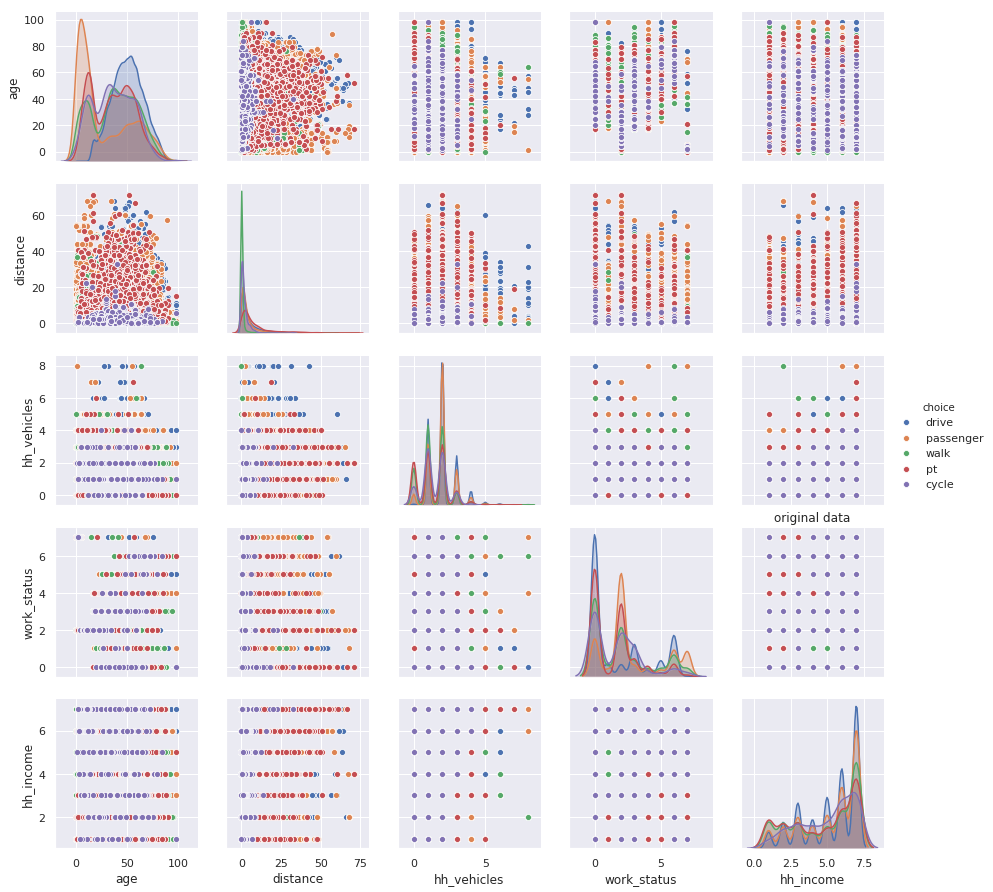

In [51]:
plt.figure(figsize=(20,20))

sns.pairplot(df[var], hue='choice', hue_order=df.choice.unique())

plt.title('original data')

plt.savefig('../figures/tgan-chicago/joint/original.png', bbox_inches='tight')

<Figure size 1440x1440 with 0 Axes>

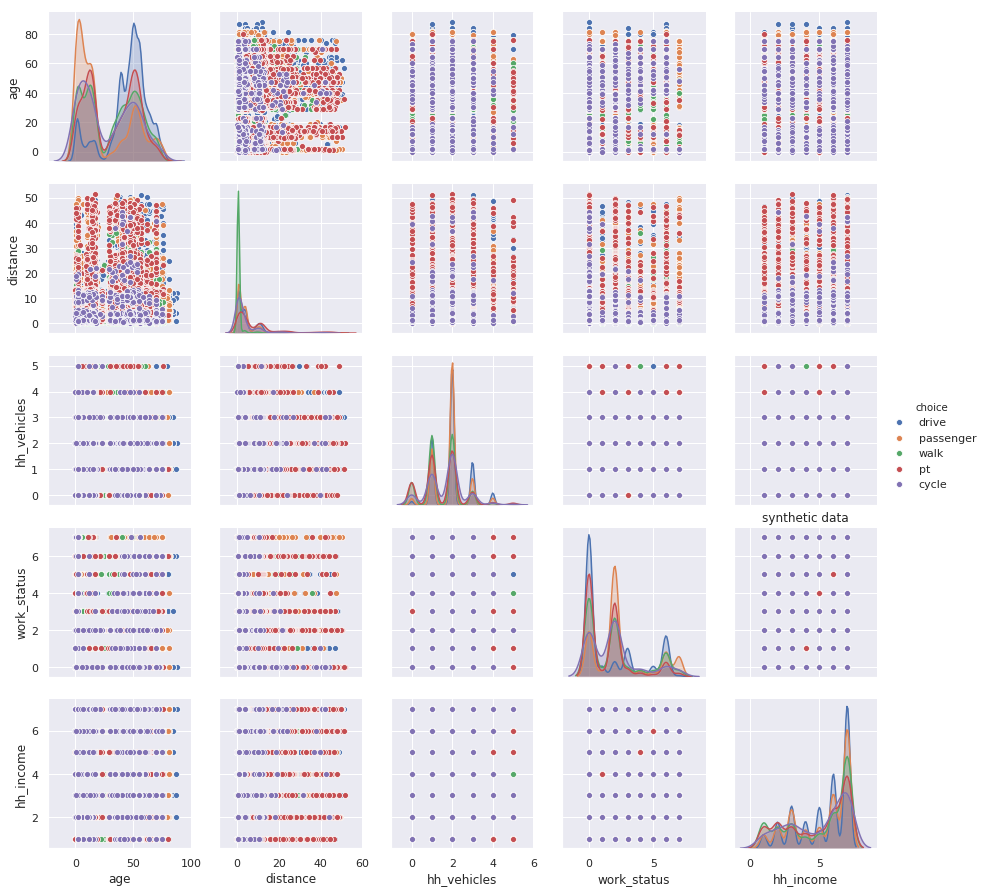

In [52]:
plt.figure(figsize=(20,20))

sns.pairplot(samples[var], hue='choice', hue_order=df.choice.unique())

plt.title('synthetic data')

plt.savefig('../figures/tgan-chicago/joint/synthetic.png', bbox_inches='tight')

<Figure size 1440x1440 with 0 Axes>

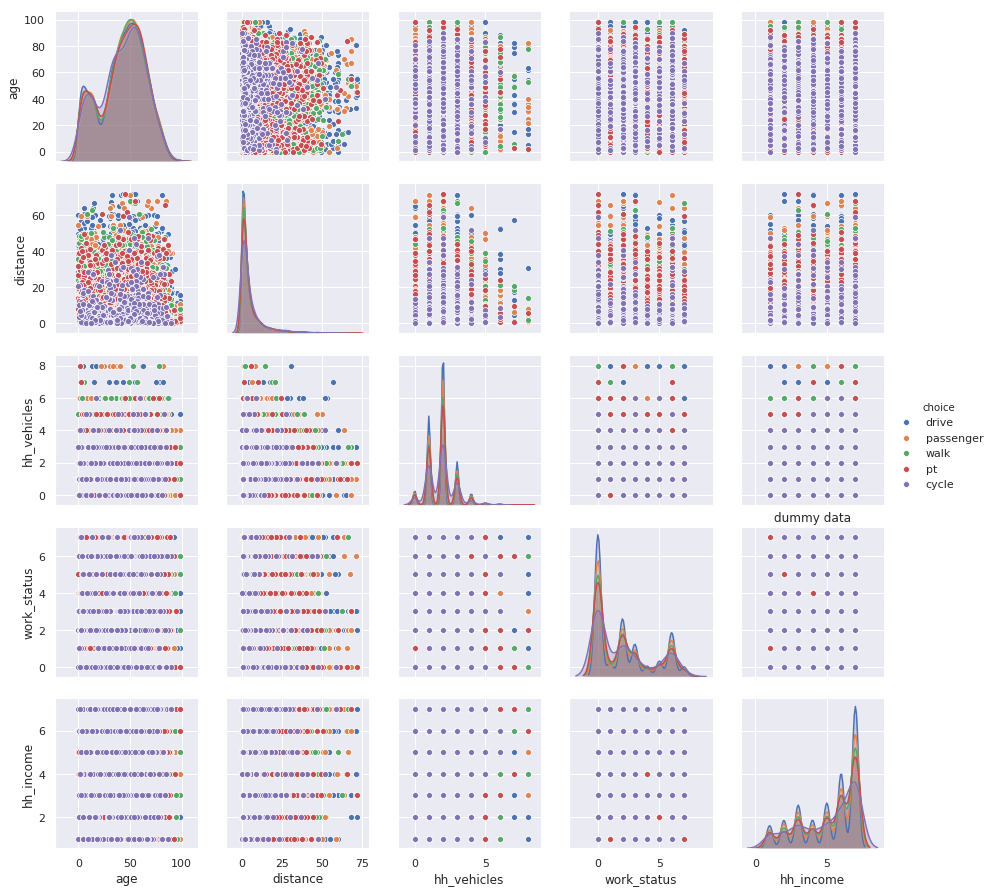

In [53]:
plt.figure(figsize=(20,20))

sns.pairplot(dummy[var], hue='choice', hue_order=df.choice.unique())

plt.title('dummy data')

plt.savefig('../figures/tgan-chicago/joint/dummy.png', bbox_inches='tight')